In [ ]:
!pip install kornia==0.3.1
!pip install torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install pytorch-lightning==0.9.0rc2  
# !pip install wandb
!pip install neptune-client

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import argparse
import multiprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path
from PIL import Image

from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision.datasets import ImageFolder
import pytorch_lightning as pl

# import wandb
# from pytorch_lightning.loggers import WandbLogger
import neptune
from pytorch_lightning.loggers import NeptuneLogger


from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

import sys
sys.path.append('/content/drive/My Drive/hateful_memes/')
from byol_pytorch import BYOL

from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
from sklearn.cluster import KMeans, DBSCAN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#wandb.init(project='byol')
neptune.init(api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiNWYyMzI4ZTYtYmNhYy00MTVjLTg3ZTQtMGJhMzRkNmNiNTBiIn0=',
             project_qualified_name='onopkosonja/byol')

### Hyperparameters

In [3]:
def get_model(version, pretrained):
    pr_flag = 'pretrained' if pretrained else 'not_pretrained'

    if version == 18:
      net = models.resnet18(pretrained=pretrained)
      save_name = 'resnet18_' + pr_flag

    elif version == 50:
      net = models.resnet50(pretrained=pretrained)
      save_name = 'resnet50_' + pr_flag
      
    return net, save_name

In [4]:
RESNET, SAVE_NAME = get_model(18, False)
BATCH_SIZE   = 32
EPOCHS       = 1000
LR           = 3e-4
NUM_GPUS     = 1
IMAGE_SIZE   = 256
IMAGE_EXTS   = ['.png']
NUM_WORKERS  = multiprocessing.cpu_count()

### Classes for training

In [14]:
# pytorch lightning module

class SelfSupervisedLearner(pl.LightningModule):
    def __init__(self, net, **kwargs):
        super().__init__()
        self.learner = BYOL(net, **kwargs)

    def forward(self, images):
        return self.learner(images)

    def training_step(self, images, _):
        loss = self.forward(images)
        return {'loss': loss} 

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        self.logger.experiment.log_metric('train_loss', avg_loss)
        #self.logger.log_metrics({'train_loss': avg_loss})
        return {'train_loss': avg_loss}

    def validation_step(self, images, _):
        loss = self.forward(images)
        return {'val_loss': loss}

    def validation_epoch_end(self, outputs):
         avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
         #self.logger.log_metrics({'val_loss': avg_loss})
         self.logger.experiment.log_metric('val_loss', avg_loss)
         return {'val_loss': avg_loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=LR)

    def on_before_zero_grad(self, _):
        self.learner.update_moving_average()

# images dataset

def expand_greyscale(t):
    return t.expand(3, -1, -1)

class ImagesDataset(Dataset):
    def __init__(self, folder, image_size):
        super().__init__()
        self.folder = folder
        self.paths = []
        print(folder)

        for path in Path(f'{folder}').glob('**/*'):
            _, ext = os.path.splitext(path)
            if ext.lower() in IMAGE_EXTS:
                self.paths.append(path)

        print(f'{len(self.paths)} images found')

        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Lambda(expand_greyscale)
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = self.paths[index]
        img = Image.open(path)
        img = img.convert('RGB')
        return self.transform(img)

### Dataloaders

In [5]:
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

TRAIN_DATASET = ImagesDataset('/content/drive/My Drive/hateful_memes/data/train/', IMAGE_SIZE) 
TRAIN_LOADER = DataLoader(TRAIN_DATASET, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

VAL_DATASET = ImagesDataset('/content/drive/My Drive/hateful_memes/data/val/', IMAGE_SIZE)
VAL_LOADER = DataLoader(VAL_DATASET, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

image_folder = ImageFolder('/content/drive/My Drive/hateful_memes/data/train/', transform=data_transform)
DATALOADER_FROM_IMG_FODLER = DataLoader(image_folder, batch_size=BATCH_SIZE)

NameError: ignored

### Training

In [ ]:
# experiment = project.get_experiments(id='BYOL-13')[0]

https://ui.neptune.ai/onopkosonja/byol/e/BYOL-14


NeptuneLogger will work in online mode


In [ ]:
model = SelfSupervisedLearner(
    RESNET,
    image_size = IMAGE_SIZE,
    hidden_layer = 'avgpool',
    projection_size = 256,
    projection_hidden_size = 4096,
    moving_average_decay = 0.99)

checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/My Drive/hateful_memes/checkpoints/' + SAVE_NAME + '_{epoch}',
    save_top_k = -1, monitor='train_loss')

#wandb_logger = WandbLogger(name=SAVE_NAME, project='byol')

neptune_logger = NeptuneLogger(
    api_key="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiNWYyMzI4ZTYtYmNhYy00MTVjLTg3ZTQtMGJhMzRkNmNiNTBiIn0=",
    project_name="onopkosonja/byol",
    experiment_name="resnet18_not_pretrained")

trainer = pl.Trainer(logger=neptune_logger, gpus=NUM_GPUS, max_epochs=EPOCHS, checkpoint_callback=checkpoint_callback,
                     ,resume_from_checkpoint='/content/drive/My Drive/hateful_memes/checkpoints/' + SAVE_NAME + '_epoch=139.ckpt')
trainer.fit(model, TRAIN_LOADER, VAL_LOADER)

https://ui.neptune.ai/onopkosonja/byol/e/BYOL-13/charts

### Saving embeddings

In [16]:
def save_embeddings(model_name, epoch=0, val=False):
    model = get_online_encoder(model_name, epoch)
    model.to(device)
    model.eval()

    embs = []
    for imgs in tqdm(iter(DATALOADER_FROM_IMG_FODLER)):
        with torch.no_grad():
            imgs_tensor = imgs[0]
            imgs_tensor = imgs_tensor.to(device)
            emb = model(imgs_tensor)
        embs.extend(emb)
        
    embs = np.array([emb.cpu().numpy() for emb in embs])
    embs = embs.squeeze()

    embedding_path = '/content/drive/My Drive/hateful_memes/embeddings/'
    val_flag = '_val' if val else ''

    if model_name == 'resnet18':
      emb_file = embedding_path + model_name + '.npy' + val_flag
      with open(emb_file, 'wb') as f:
        np.save(f, embs)
    
    else:
      emb_file = embedding_path + model_name + '_epoch={}.npy'.format(epoch) + val_flag
      with open(emb_file, 'wb') as f:
          np.save(f, embs)

    print(f'Saved embeddings for {model_name} trained for {epoch} epochs to {emb_file} file')


def get_online_encoder(model_name, epoch):
    if model_name == 'resnet18':
      model = models.resnet18(pretrained=True)

    else:
      checkpoint_path = '/content/drive/My Drive/hateful_memes/checkpoints/' + model_name + '_epoch={}.ckpt'.format(epoch)
      checkpoint = torch.load(checkpoint_path)
      print(f'Loaded {checkpoint_path} checkpoint.')

      byol = SelfSupervisedLearner(
        RESNET,
        image_size = IMAGE_SIZE,
        hidden_layer = 'avgpool',
        projection_size = 256,
        projection_hidden_size = 4096,
        moving_average_decay = 0.99)

      byol.load_state_dict(checkpoint['state_dict'])
      model = byol.learner.online_encoder.net
      
    model = nn.Sequential(*(list(model.children())[:-1]))
    return model

In [ ]:
save_embeddings(model_name='resnet18_not_pretrained', epoch=139)

### T-SNE

In [25]:
def get_tsne(model_name, epoch, val=False):
  embedding_path = '/content/drive/My Drive/hateful_memes/embeddings/'
  val_flag = '_val' if val else ''

  with open(embedding_path + model_name + '_epoch=0.npy' + val_flag, 'rb') as f:
    random_emb = np.load(f)

  with open(embedding_path + model_name + '_epoch={}.npy'.format(epoch) + val_flag, 'rb') as f:
    trained_emb = np.load(f)

  with open(embedding_path + 'labels' + val_flag + '.npy', 'rb') as f:
    labels = np.load(f)

  tsne_random = TSNE()
  X_random = tsne_random.fit_transform(random_emb)

  tsne_trained = TSNE()
  X_trained = tsne_trained.fit_transform(trained_emb)

  return plot_tsne([0, epoch], X_random, X_trained, labels)

def plot_tsne(epochs, tsne_random, tsne_trained, labels):
  tsne = [tsne_random, tsne_trained]

  fig = plt.figure(figsize=(20, 10))
  for i, t in enumerate(tsne):
    plt.subplot(1, 2, i + 1)
    plt.title('t-sne for {} after {} epoch'.format(SAVE_NAME, epochs[i]))
    sns.scatterplot(t[:,0], t[:,1], hue=labels)
  plt.show()

#### resnet18 not pretrained

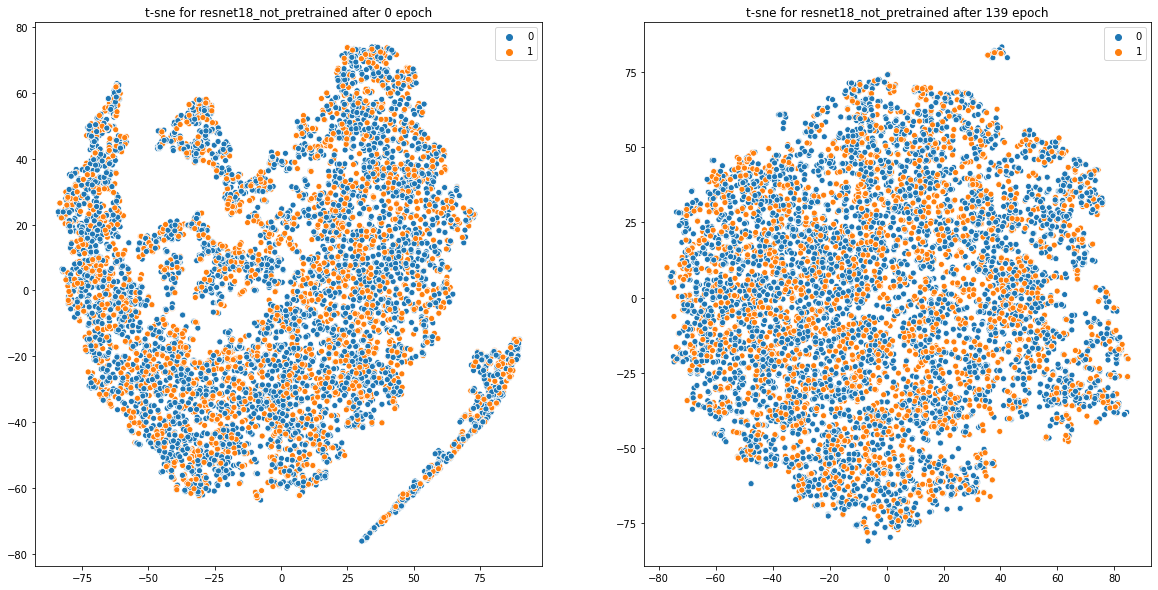

In [26]:
 get_tsne('resnet18_not_pretrained', 139)

### KNN

In [33]:
def find_nearest_neighbors(model, epoch=0, n_neighbors=5):
  embedding_path = '/content/drive/My Drive/hateful_memes/embeddings/'
  if model == 'resnet18':
    with open(embedding_path + model + '.npy', 'rb') as f:
      emb = np.load(f)
  
  else:
    with open(embedding_path + model + '_epoch={}.npy'.format(epoch), 'rb') as f:
      emb = np.load(f)
    
  nbrs = NearestNeighbors(n_neighbors=n_neighbors+1)
  nbrs.fit(emb)

  _, indices = nbrs.kneighbors(emb)
  return indices

def plot_knn_examples(knn_idx, val=False):
  embedding_path = '/content/drive/My Drive/hateful_memes/embeddings/'
  val_flag = '_val' if val else ''
  with open(embedding_path + 'labels' + val_flag + '.npy', 'rb') as f:
    labels = np.load(f)

  n, k = knn_idx.shape

  for i, imgs_idx in enumerate(knn_idx):
    fig = plt.figure(figsize=(20, 10))

    for j, img_idx in enumerate(imgs_idx):
      plt.subplot(n, k, i * k + j + 1)
      img_folder_idx = knn_idx[i][j]
      img_path, _ = DATALOADER_FROM_IMG_FODLER.dataset.samples[img_folder_idx]
      img_label = labels[img_folder_idx]
      img = plt.imread(img_path)
      plt.title('№ {}, label {}'.format(img_path.rsplit('/')[-1], img_label))
      plt.imshow(img)
  plt.show()


### resnet18 not pretrained






In [34]:
random_img = np.random.randint(0, len(TRAIN_DATASET), 5)

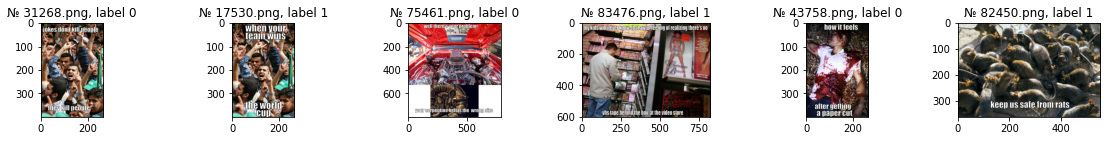

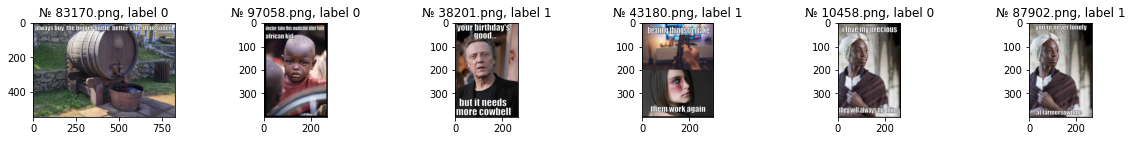

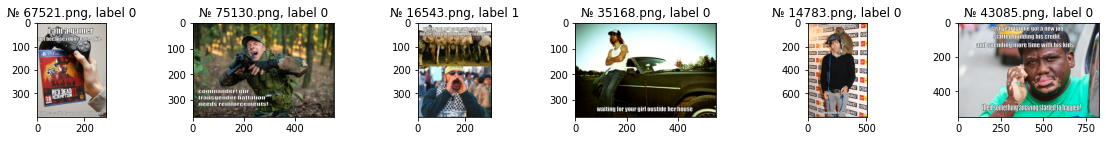

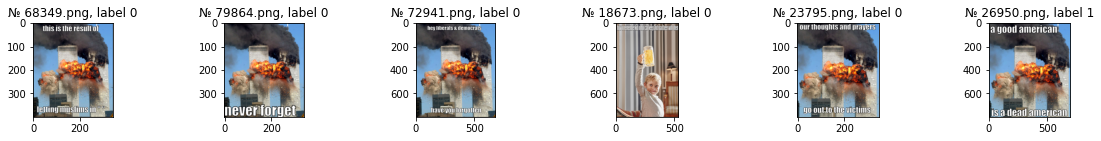

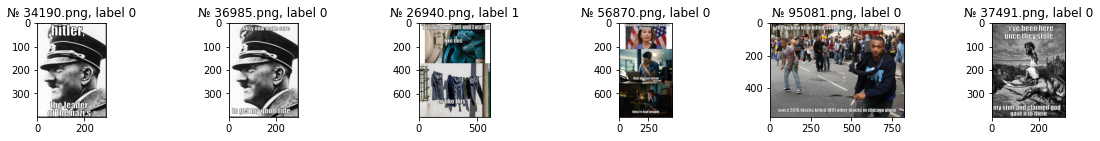

In [35]:
model = 'resnet18_not_pretrained'
knn_idx = find_nearest_neighbors(model, 0)
plot_knn_examples(knn_idx[random_img])

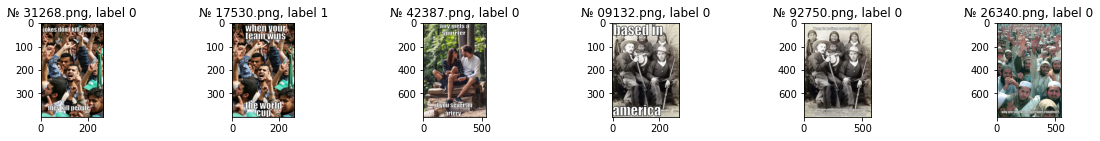

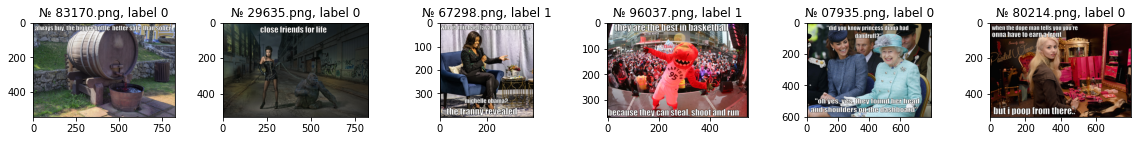

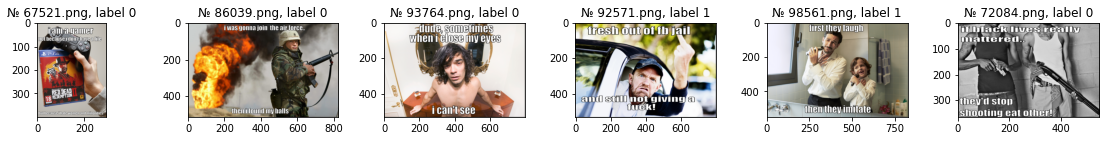

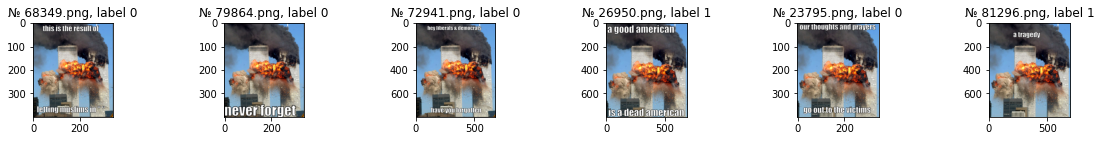

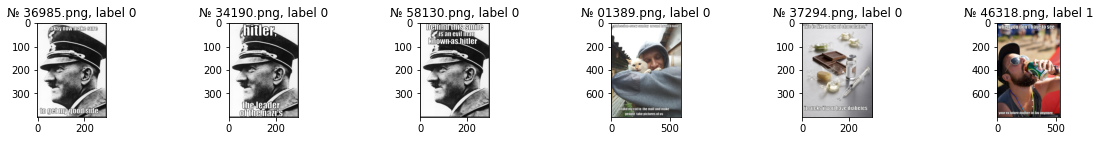

In [37]:
knn_idx = find_nearest_neighbors(model, 139)
plot_knn_examples(knn_idx[random_img])

### Classification

In [10]:
def calculate_loss(X, y, model):
    pred = model(X)
    return nn.functional.binary_cross_entropy(pred, y.unsqueeze(1)) 

def train(model, epochs=100):
    optimizer = torch.optim.Adam(model.parameters())
    train_losses = []
    val_losses = []
    model.to(device)
    for i in range(epochs):
        #Train
        loss_mean = 0
        elements = 0
        for X, y in iter(TRAIN_LOADER):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_mean += loss.item() * len(X)
            elements += len(X)
        train_losses.append(loss_mean / elements)
        #Validation
        loss_mean = 0 
        elements = 0
        for X, y in iter(VAL_LOADER):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            loss_mean += loss.item() * len(X)
            elements += len(X)
        val_losses.append(loss_mean / elements)
        print("Epoch", i, "| Train loss", train_losses[-1], "| Validation loss", val_losses[-1])
    return train_losses, val_losses

def plot_losses(train_l, val_l):
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train_l)), train_l, label="train")
    plt.plot(range(len(val_l)), val_l, label="validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [11]:
embedding_path = '/content/drive/My Drive/hateful_memes/embeddings/'
labels_train = torch.Tensor(np.load(embedding_path + 'labels.npy'))
labels_val = torch.Tensor(np.load(embedding_path + 'labels_val.npy'))

In [12]:
classifier = nn.Sequential(
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, 1),
                nn.Sigmoid())

path_train = embedding_path + 'resnet18_not_pretrained_epoch=139.npy'
path_val = embedding_path + 'resnet18_not_pretrained_epoch=139_val.npy'

emb_train = torch.Tensor(np.load(path_train).astype(np.float32))
emb_val = torch.Tensor(np.load(path_val).astype(np.float32))

dataset_train = TensorDataset(emb_train, labels_train)
dataset_val = TensorDataset(emb_val, labels_val)

TRAIN_LOADER = DataLoader(dataset_train, batch_size=128)
VAL_LOADER = DataLoader(dataset_val, batch_size=128)

Epoch 0 | Train loss 0.6584689501594094 | Validation loss 0.6998885760307312
Epoch 1 | Train loss 0.6673471503538244 | Validation loss 0.7227639560699463
Epoch 2 | Train loss 0.6562802690618178 | Validation loss 0.72280171251297
Epoch 3 | Train loss 0.6560350730559406 | Validation loss 0.7234517936706543
Epoch 4 | Train loss 0.655759049135096 | Validation loss 0.7241070966720581
Epoch 5 | Train loss 0.6555320213542265 | Validation loss 0.7246571712493897
Epoch 6 | Train loss 0.6553372503729428 | Validation loss 0.7251483449935913
Epoch 7 | Train loss 0.6551223752077888 | Validation loss 0.7252814197540283
Epoch 8 | Train loss 0.6550900261822868 | Validation loss 0.7253624711036682
Epoch 9 | Train loss 0.6549146111432244 | Validation loss 0.7260463047027588
Epoch 10 | Train loss 0.6547088650535134 | Validation loss 0.7262528324127198
Epoch 11 | Train loss 0.6545606166615205 | Validation loss 0.7265892701148987
Epoch 12 | Train loss 0.6544672442043529 | Validation loss 0.7267608861923218

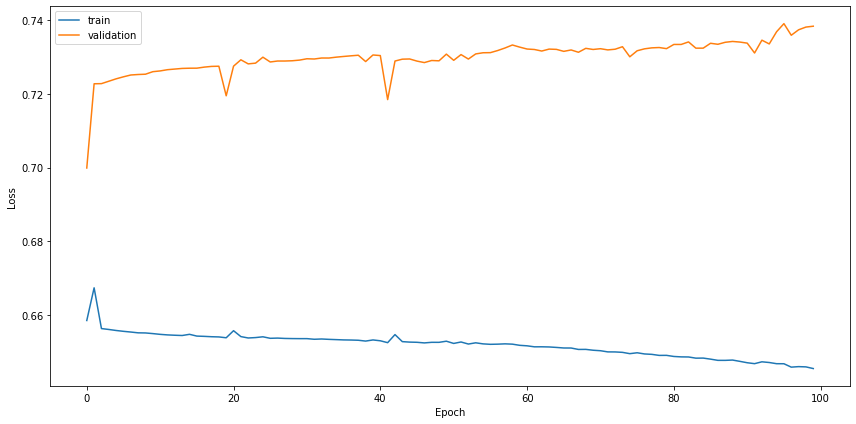

In [13]:
train_l, val_l = train(classifier)
plot_losses(train_l, val_l)

## Clustering


### k-means

In [14]:
def k_means(embeddings, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    distances = kmeans.fit_transform(embeddings)
    closest_distances = np.min(distances, axis=1)
    return np.mean(closest_distances)

def plot_kmeans_params(embeddings, n_clusters_list):
    mean_distances = [k_means(embeddings, n_clusters) for n_clusters in n_clusters_list]
    plt.plot(n_clusters_list, mean_distances)
    plt.title('K-means')
    plt.xlabel('Number of clusters')
    plt.ylabel('Mean distance from point \n to the nearest centroid')
    plt.show()

#### resnet18 not pretrained

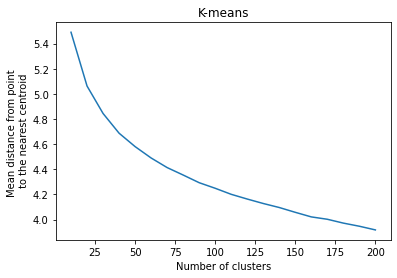

In [17]:
embeddings = np.load('/content/drive/My Drive/hateful_memes/embeddings/resnet18_not_pretrained_epoch=139.npy')
n_clusters = np.arange(10, 201, 10)
plot_kmeans_params(embeddings, n_clusters)

### DBSCAN

In [18]:
def dbscan(embeddings, eps=0.5, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(embeddings)
    labels = dbscan.labels_
    n_clusters = len(np.unique(labels)) - 1
    n_noisy = len(np.where(labels == -1)[0])
    return n_clusters, n_noisy
    

def plot_dbscan_params(embeddings, eps_list=None, min_samples_list=None):
    if eps_list is not None:
        params_eps = [dbscan(embeddings, eps=eps) for eps in eps_list]
        clusters_eps, noisy_eps = list(zip(*params_eps))
        x_data = eps_list
        y_data = [np.array(clusters_eps), np.array(noisy_eps)]
        x_title = 'Maximum distance between neighbors'
              
    else:
        params_samples = [dbscan(embeddings, min_samples=samples) for samples in min_samples_list]
        clusters_samples, noisy_samples = list(zip(*params_samples))
        x_data = min_samples_list
        y_data = [np.array(clusters_samples), np.array(noisy_samples)]
        x_title = 'Number of neighbors'
        
    y_titles = ['Number of clusters', 'Number of noise samples']
    
    fig = plt.figure(figsize=(20, 10))
    for i, x in enumerate(y_data):
        plt.subplot(1, 2, i + 1)
        plt.title('DBSCAN')
        plt.xlabel(x_title)
        plt.ylabel(y_titles[i])
        plt.plot(x_data, y_data[i])
    plt.show()

#### resnet18 not pretrained

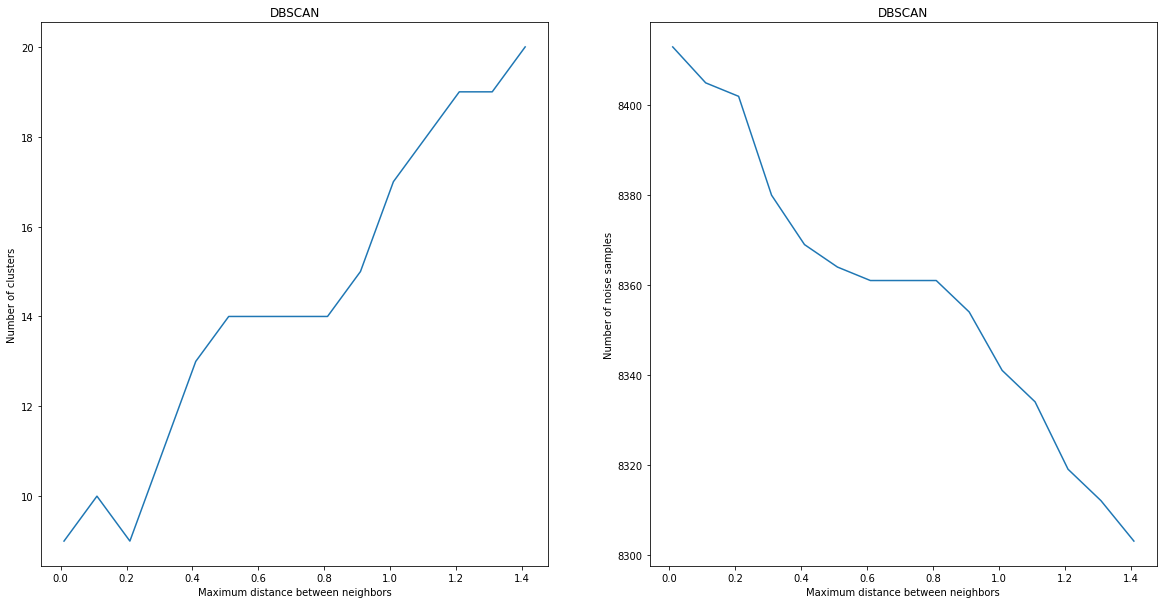

In [20]:
embeddings = np.load('/content/drive/My Drive/hateful_memes/embeddings/resnet18_not_pretrained_epoch=139.npy')
eps = np.arange(0.01, 1.5, 0.1)
plot_dbscan_params(embeddings, eps_list=eps)

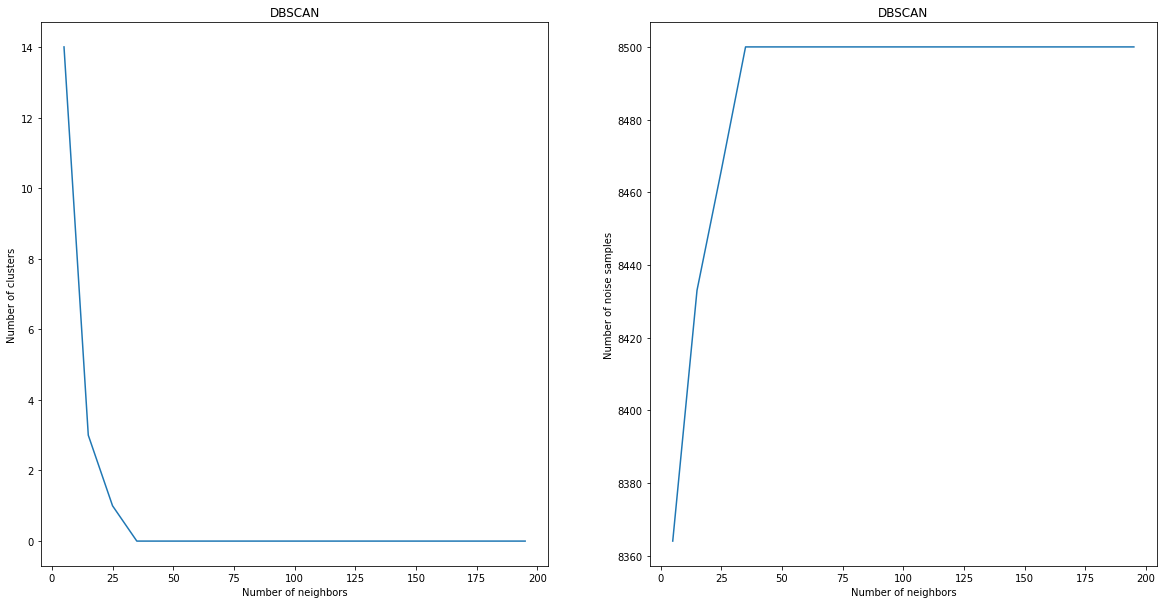

In [24]:
samples = np.arange(5, 200, 10)
plot_dbscan_params(embeddings, min_samples_list=samples)